## This code will recommend games to a player using reviews each game received from each player and what games that player played the most.

In order to test this, please write a player's steam game id in to the input. If nothing is written, the default id will be placed to run the code

In [4]:
test_id=input('Enter a player id: ')

Enter a player id: 


In [5]:
if len(test_id)!=17 and not test_id.isdigit():
    test_id=76561198141485825

We will first gather game review data from STEAM using API.

In [6]:
import requests
# Get all the games that the player played
def getownedgames(idnum):
    """Takes the id number of a steam user and returns the id num of games they own"""
    url='http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key=3A629E52AE594CB777253431189F2967&steamid={}&format=json'.format(idnum)
    r=requests.get(url)
    json_data=r.json()
    return json_data

In [7]:
def get_reviews(gameid,num):
    """Takes the id number of a game and returns 20 reviews"""
    url='http://store.steampowered.com/appreviews/{}?json=1&start_offset={} '.format(gameid,num)
    r=requests.get(url)
    json_data=r.json()
    return json_data

In [8]:
import pandas as pd
def get_all_reviews(gameid):
    """Uses 'get_review' function to pull as many reviews as it can from steam website"""
    """STEAM website usually have limitation (20 reviews) on how many reviews we can pull"""
    n=0
    stop=0
    fst_iterat=get_reviews(gameid,n)
    if fst_iterat['success']==1:
        df=pd.DataFrame(fst_iterat['reviews'])
        numreview=fst_iterat['query_summary']['num_reviews']             
        while numreview==20:
            if len(df)>=120:
                break
            n+=20
            add_iterat=get_reviews(gameid,n)
            df_add=pd.DataFrame(add_iterat['reviews'])
            df=df.append(df_add)
            numreview=add_iterat['query_summary']['num_reviews']
        df_author=pd.DataFrame(df['author'].tolist())
        df['author']=df_author['steamid']
    return df[['author','recommendationid','language','review','steam_purchase','timestamp_created','timestamp_updated']]

Get all the application id that is on STEAM website.

In [9]:
api_key='3A629E52AE594CB777253431189F2967' # API key for getting information from Steam
allgame='http://api.steampowered.com/ISteamApps/GetAppList/v0002/?key={}&format=json'.format(api_key)
all_r=requests.get(allgame)
allgame_id=all_r.json()

In [10]:
steamapp_dict=dict()
for num in range(len(allgame_id['applist']['apps'])):
    key=allgame_id['applist']['apps'][num]['appid']
    value=allgame_id['applist']['apps'][num]['name']
    if key in steamapp_dict:
        continue
    else:
        steamapp_dict[key]=value

In [69]:
steamapp_dict[10]

'Counter-Strike'

In [11]:
len(steamapp_dict)

76832

For the sake of our code, we will use a portion of the steam apps because iterating over hundreds of reviews from 76479 apps will be very time consuming.
The games that we will recommending to the consumer was determined by looking at the ranking on metacritic.

Metacritic have their own way of determining the rankings including opinions from game reviewers, popularity from players, etc.

However, not every game from metacritic is on STEAM website and not all names are the same in these two websites.

Therefore we will use top 300 game names from metacritic and find games on STEAM that shares a part of that name(e.g. "Witcher 3" vs. "Witcher 3: Wild hunt" or "Witcher 2: Assassins of Kings")

In [12]:
top300file=open('E:\Desktop\jupyter\metacritic top 300.txt','r').read().split('\n')

to make the comparison easier, each game names will be tokenized and lower cased

In [13]:
games_names_lowered=[name.lower() for name in steamapp_dict.values()]
new_game_names=zip(games_names_lowered,steamapp_dict.values())

In [14]:
token_w_origin=list(new_game_names)

Stopwords including punctuation and version codes are removed

In [15]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

all_stops = stopwords.words('english')+list(string.punctuation)+['I','II','III','IV','V','VI','game','games','play']

filter out words that are included in stopwords and the words that are composed of numbers (e.g.1,2,3,4,5, ... )

In [16]:
ranked_game_list=list()
for name in top300file:
    tokens=word_tokenize(name)
    words=[word1.lower() for word1 in tokens if word1 not in all_stops]
    only_words=[word2 for word2 in words if not word2.isdigit()]
    if only_words not in ranked_game_list:
        ranked_game_list.append(only_words)

identify games that have more same tokens than the number of tokens that comprise the game name 

In [17]:
keys_of_good_games=list()
names_of_good_games=list()
for element in ranked_game_list:
    if len(element)==0:
        continue
    number_of_matched_words=len(element)
    if number_of_matched_words==0:
        number_of_matched_words=1
    for num in range(len(token_w_origin)):
        steam_game=token_w_origin[num][0].split()
        matches = {token for token in steam_game if token in element}
        if len(matches)>=number_of_matched_words:
            key=list(steamapp_dict.keys())[list(steamapp_dict.values()).index(token_w_origin[num][1])]
            keys_of_good_games.append(key)
            names_of_good_games.append(token_w_origin[num][1])
        else:
            continue

In [18]:
len(keys_of_good_games)

2690

filter out the duplicates

In [19]:
keys_of_good_games=list(set(keys_of_good_games))

In [20]:
len(keys_of_good_games)

2525

retrieve all the review data from the games that are in the list "keys_of_good_games"
This takes a while, so it should be saved as pickle

In [ ]:
#pickle

for key in keys_of_good_games:
    try:
        df=get_all_reviews(key)
        print(key)
    except: 
        continue
        print('failed')
    df['game_name']=steamapp_dict.get(key)
    if 'review_df' not in locals():
        review_df=df
    else:
        review_df=review_df.append(df, ignore_index=True, sort=False)

In [21]:
import pickle

Now that we have the database to get games from, we will test it with a player.

In [22]:
file_name='testfile'

In [23]:
review_df=pickle.load(open(file_name,"rb"))

In [24]:
review_df.head(10)

,author,recommendationid,language,review,steam_purchase,timestamp_created,timestamp_updated,game_name
0,76561198116100475,49214617,english,A little biased as I got this for 'free' with ...,True,1551026300,1551026424,"Mafia III: Faster, Baby!"
1,76561198116100475,49334938,english,On a sale - HELLA YES!\nWithout a discount - N...,True,1551614792,1551614792,Mafia III: Stones Unturned
2,76561198116100475,49301576,english,Why isn't the Main Game like this DLC?\nAbsolu...,True,1551470571,1551470571,Mafia III: Sign of the Times
3,76561198821796334,49358363,english,Pretty fucking hard but very cool game!,True,1551720577,1551720577,Spelunky
4,76561198133963882,49386129,english,"I don't even play many platformers, but I stil...",True,1551833236,1551833236,Spelunky
5,76561198043141890,49283358,english,Just one... more... horribly... brutal... deat...,True,1551380309,1551380309,Spelunky
6,76561198063251252,49264539,english,Its hard.,True,1551282914,1551282914,Spelunky
7,76561198058640737,49079132,english,★★★★★\n\nWhip arrows,True,1550520690,1550520690,Spelunky
8,76561198836750310,49150591,english,Don't think about graphics. Still it's so much...,True,1550819202,1550819202,Counter-Strike
9,76561198849360285,49434533,english,Old but Gold,True,1552058322,1552058322,Counter-Strike


In [25]:
from langdetect import detect

In [26]:
from langdetect import DetectorFactory 
DetectorFactory.seed = 0

In [27]:
lang=list()
for num in range(len(review_df['review'])):
    try: 
        detected=detect(review_df['review'][num])
        lang.append(detected)
    except:
        lang.append('NaN')

In [28]:
review_df['detected_lang']=lang
review_df=review_df[review_df['detected_lang']=='en']

Define function to take all the review data into documents; one review document from each game

In [29]:
def amalgamate(df):
    dumped_dict=dict()
    for name in df['game_name'].unique():
        dump=df.loc[(df['game_name']==name)]['review'].sum(axis=0)
        dumped_dict[name]=dump
    return dumped_dict

In [30]:
allgamedatabase=amalgamate(review_df)

save the game data of a player in the variable: testperson
extract the game ids and the time the player spent on each game: testids, testplaytimes

In [31]:
def rawplayergamelist(_id):
    gamelist=getownedgames(_id)['response']['games']
    return gamelist

In [32]:
testperson=rawplayergamelist(test_id)

In [33]:
testids=list()
testplaytimes=list()
for i in range(len(testperson)):
    testids.append(testperson[i]['appid'])
    testplaytimes.append(testperson[i]['playtime_forever'])

In [34]:
test_df=pd.DataFrame(list(zip(testids,testplaytimes)),columns=['ids','playtime']).sort_values('playtime',ascending=False)
playedgame_name=list()
for id_ in test_df['ids']:
    name=steamapp_dict.get(id_)
    playedgame_name.append(name)
test_df['name']=playedgame_name

select the games that are present in the database we set up for this analysis and make a new dataframe comprised of playtime and game ids: test_df

In [35]:
test_df.head()

,ids,playtime,name
27,72850,38007,The Elder Scrolls V: Skyrim
53,219740,10490,Don't Starve
15,33230,5768,Assassin's Creed II
39,317110,5524,Uncharted Waters Online: Episode Atlantis
32,242050,4405,Assassin's Creed IV Black Flag


pick most played game in the list and retreive all the reviews that are present there : player_df

default number of games is 15 but if the player played less than 15 games, it will adjust to the games that the player played for at least 30 minutes

In [36]:
if len(test_df[test_df['playtime']>=30])<15:
    topplayedgame=test_df[test_df['playtime']>=30]
else:
    topplayedgame=test_df[0:15]

In [37]:
topplayedgame=topplayedgame.set_index('ids')

In [38]:
topplayedgame.index

Int64Index([ 72850, 219740,  33230, 317110, 242050,  22330,  48190, 413150,
            391540, 205100, 311560, 208480, 368500, 201870, 261570],
           dtype='int64', name='ids')

get all reviews of the games this player enjoys: player_df

In [39]:
error=list()
for ids in topplayedgame.index:
    try:
        data=get_all_reviews(ids)
        data['game_name']=steamapp_dict.get(ids)
        if 'player_df' not in locals():
            player_df=data
        else:
            player_df=player_df.append(data, ignore_index=True, sort=False)
    except:
        error.append(ids)
        topplayedgame['name']

In [40]:
topplayedgame=topplayedgame.drop(error)

In [41]:
topplayedgame

,playtime,name
ids,,
72850,38007,The Elder Scrolls V: Skyrim
219740,10490,Don't Starve
33230,5768,Assassin's Creed II
242050,4405,Assassin's Creed IV Black Flag
22330,3391,The Elder Scrolls IV: Oblivion
48190,2773,Assassin's Creed Brotherhood
413150,2250,Stardew Valley
391540,1726,Undertale
205100,1542,Dishonored


In [42]:
player_df.head()

,author,recommendationid,language,review,steam_purchase,timestamp_created,timestamp_updated,game_name
0,76561198074610624,49395835,english,DLC Page\n-------------\n\nhttps://store.steam...,True,1551882372,1551882372,The Elder Scrolls V: Skyrim
1,76561198313601265,49327139,english,"Great game, horrible publisher. Really wish Be...",True,1551580578,1551580578,The Elder Scrolls V: Skyrim
2,76561198170531813,49743905,english,DLC Page\n-------------\n\nhttps://store.steam...,True,1553464211,1553464235,The Elder Scrolls V: Skyrim
3,76561198067648820,49771800,english,"If you want the original Skyrim game + DLCs,\n...",True,1553613173,1553613173,The Elder Scrolls V: Skyrim
4,76561198122616211,49603949,english,Bethesda gay but Skyrim good,True,1552785967,1552785967,The Elder Scrolls V: Skyrim


In order to use cosine similarity to compare these lists to other games, all the reviews from each games are made into one big corpus. i.e. one corpus each for all the game respectively.

In [43]:
player_dict=amalgamate(player_df)

In [44]:
player_dict.keys()

dict_keys(['The Elder Scrolls V: Skyrim', "Don't Starve", "Assassin's Creed II", "Assassin's Creed IV Black Flag", 'The Elder Scrolls IV: Oblivion ', "Assassin's Creed Brotherhood", 'Stardew Valley', 'Undertale', 'Dishonored', "Assassin's Creed Rogue", "Assassin's Creed® III", "Assassin's Creed Syndicate", "Assassin's Creed Revelations", 'Ori and the Blind Forest'])

In [45]:
for_analysis={**allgamedatabase,**player_dict}

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk.stem

In [47]:
import re
stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

vectorizer_s = StemmedCountVectorizer(analyzer="word", stop_words=all_stops,ngram_range=(1,2),min_df=0.01,token_pattern=r'\b[^\d\W]+\b')

In [48]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

tfidf_s = StemmedTfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word', stop_words=all_stops,ngram_range=(1,2),min_df=0.01,token_pattern=r'\b[^\d\W]+\b')

In [49]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [50]:
text=player_df.review.sum(axis=0)

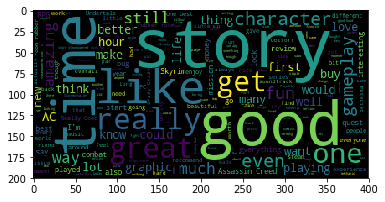

In [51]:
wordcloud=WordCloud(stopwords=all_stops).generate(text)
plt.imshow(wordcloud)

From all the games this player played, the term "story" pops up quite a lot giving us a clue that this player enjoys games that has story element to it.

"time" also shows up quite a lot but it is unsure just from this wordcloud whether that means a game that takes a lot of time to play or the opposite.




<br>
Using only the stems of each words, I calculate the TF-IDF scores of the reviews

In [65]:
def stemvect(text):
    X=vectorizer_s.fit_transform(text)
    return X.toarray(), vectorizer_s.get_feature_names()

In [66]:
def stemtfidf(text):
    X=tfidf_s.fit_transform(text)
    return X.toarray(),tfidf_s.get_feature_names()

In [67]:
freq,words=stemvect(for_analysis.values())
tdfscore,tdfwords=stemtfidf(for_analysis.values())

In [55]:
games_tdf=pd.DataFrame(tdfscore,index=for_analysis.keys(),columns=tdfwords)

In [56]:
games_tdf.head()

,aaa,abandon,abil,abl,able get,absolut,absolutely lov,absolutely noth,abus,ac,...,young,younger,your,youtu,youtub,youtube com,zero,zombi,zone,zoom
"Mafia III: Faster, Baby!",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mafia III: Stones Unturned,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mafia III: Sign of the Times,0.0,0.0,0.0,0.0,0.0,2.786696,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spelunky,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Counter-Strike,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,4.961448,0.0,0.0,0.0,0.0,0.0,0.0,0.0


These will in turn be used to calculate cosine similarity with each other: matrixforgame

This allows us to find out how similar each game's reviews are to others, which in turn implies how similar each game is to the other

In [57]:
list_of_games=games_tdf.index.tolist()
listlength=len(list_of_games)
import numpy as np
from scipy import spatial
matrixforgame=np.zeros(shape=(listlength,listlength))
for i in range(len(list_of_games)):
    game=list_of_games[i]
    for j in range(len(list_of_games)):
        another=list_of_games[j]
        if game!=another:
            result=1-spatial.distance.cosine(games_tdf.loc[game].values,games_tdf.loc[another].values)
            matrixforgame[i][j]=result

C:\Users\shshi\Anaconda3\lib\site-packages\scipy\spatial\distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [58]:
result_df=pd.DataFrame(matrixforgame,index=list_of_games,columns=list_of_games)

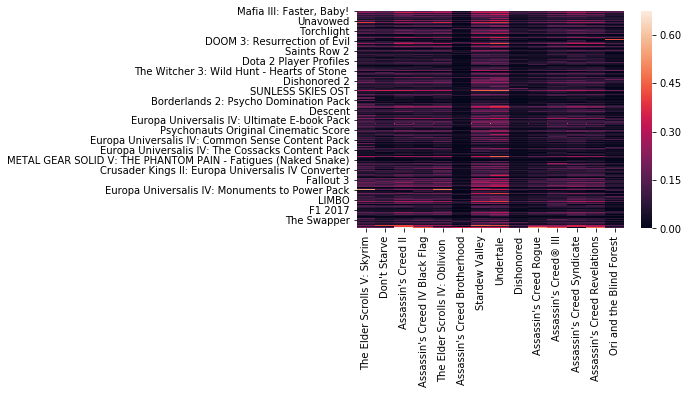

In [59]:
import seaborn as sns
sns.heatmap(result_df[topplayedgame['name']])

You can see as a heat map that there were a lot more games similar to Undertale than Assassins's Creed Brotherhood.<br>
There also seem to be a small number of game that was very similar to Ori and the Blind Forest as there is one bright band.


<br>
<br>

I added weight to each games according to how long the player played it for and added all the cosine similarity values: result_df<br>
This allows me to get a list of games that this player is likely to enjoy because they played these list of games a lot.

In [60]:
weight=len(list(player_dict.keys()))
result_df['total'] = 0
for name in player_df['game_name'].unique():
    result_df['total']=result_df['total']+(weight*result_df[name])
    weight=weight-1

remove the games that this player already possess: removed<br>
Then we take the top 10 games with the largest similarity: finaltop10recommendation

In [61]:
alreadyownedgames=test_df['name'].tolist()
removed=[name for name in result_df.index.tolist() if name not in alreadyownedgames]

In [62]:
finaltop10recommendation=result_df['total'].loc[removed].sort_values(ascending=False)[0:10]
finaltop10recommendation.index.tolist()

['Rise of the Tomb Raider',
 'Mafia III',
 'Far Cry 5',
 'Subnautica',
 'Borderlands 2',
 'RimWorld',
 'Night in the Woods',
 "Hellblade: Senua's Sacrifice",
 'Far Cry 4',
 'What Remains of Edith Finch']

To give users accessibility, I added in urls to each recommended game and presented them: recommended_games

In [78]:
recommended_games=list()
for name in finaltop10recommendation.index.tolist():
    ids=list(steamapp_dict.keys())[list(steamapp_dict.values()).index(name)]
    recommended_games.append((name,"https://store.steampowered.com/app/"+str(ids)))

In [89]:
print("\nBecause you played games such as {}, {} and {}, you will like these games as well!\n".format(alreadyownedgames[0],alreadyownedgames[1],alreadyownedgames[2]))
print(pd.DataFrame(recommended_games,columns=["Game Name","Store page"]))


Because you played games such as The Elder Scrolls V: Skyrim,Don't Starve and Assassin's Creed II, you will like these games as well!

                      Game Name                                 Store page
0       Rise of the Tomb Raider  https://store.steampowered.com/app/391220
1                     Mafia III  https://store.steampowered.com/app/360430
2                     Far Cry 5  https://store.steampowered.com/app/552520
3                    Subnautica  https://store.steampowered.com/app/264710
4                 Borderlands 2   https://store.steampowered.com/app/49520
5                      RimWorld  https://store.steampowered.com/app/294100
6            Night in the Woods  https://store.steampowered.com/app/481510
7  Hellblade: Senua's Sacrifice  https://store.steampowered.com/app/414340
8                     Far Cry 4  https://store.steampowered.com/app/298110
9   What Remains of Edith Finch  https://store.steampowered.com/app/501300
